## INTRO & SETTINGS

The goal of this tutorial is to show the capabilities of `LF2I` and its usage with a simple example: inferring the 1-dimensional mean of a Gaussian distribution with fixed variance.

In this case we will use the `Waldo` test statistic (see https://arxiv.org/abs/2205.15680)

In [1]:
import torch

PARAM_DIM = 1
DATA_DIM = 1
DATA_SAMPLE_SIZE = 1  # assume we get to see only one observed sample for each “true” parameter
CONFIDENCE_LEVEL = 0.9

## SIMULATE

Let's start from the simulator, which is used internally to generate the data needed to 
1. estimate the test statistics;
2. estimate the critical values; and 
3. diagnose the constructed confidence regions 

In [2]:
from lf2i.simulator.gaussian import GaussianMean

In [3]:
simulator = GaussianMean(
    likelihood_cov=1,
    prior='uniform',
    parameter_space_bounds={'low': -1, 'high': 1},
    param_grid_size=1000,
    param_dim=PARAM_DIM, 
    data_dim=DATA_DIM,
    data_sample_size=DATA_SAMPLE_SIZE
)

#### Observation

For simplicity, let's use the simulator to generate one “observed” sample from the likelihood as well

In [4]:
true_param = torch.Tensor([0])
observed_x = simulator.likelihood(true_param).sample(sample_shape=(DATA_SAMPLE_SIZE, ))

true_param.shape, observed_x.shape

(torch.Size([1]), torch.Size([1, 1]))

## CONFIDENCE SET by leveraging a PREDICTION ALGORITHM

Assume we want to do inference on the Gaussian mean by predicting its value given the data. `Waldo` allows to leverage any prediction algorithm to obtain a confidence region for the parameter of interest that is guaranteed to have the desired level of coverage regardless of 
1. the prior distribution;
2. the true value of the parameter;
3. the size of the observed sample

The prediction algorithm can be already trained or not. The example below assumes the algorithm (in this case GradientBoosting) has not been trained yet

In [5]:
from lf2i.inference.lf2i import WALDO

In [6]:
waldo = WALDO(
    simulator=simulator,
    estimator='gb',
    method='prediction',
    confidence_level=CONFIDENCE_LEVEL,
    conditional_variance_estimator='gb',
    estimator_kwargs={'n_estimators': 100, 'max_depth': 2},
    cond_variance_estimator_kwargs={'n_estimators': 100, 'max_depth': 2}
)

In [7]:
confidence_region = waldo.infer(x=observed_x, b=10_000, b_prime=5_000)

## DIAGNOSTICS

In [8]:
from lf2i.plot.coverage_diagnostics import coverage_regions_plot

In [13]:
parameters, mean_proba, upper_proba, lower_proba = waldo.diagnose(
    b_doubleprime=5000,
    region_type='lf2i'
)

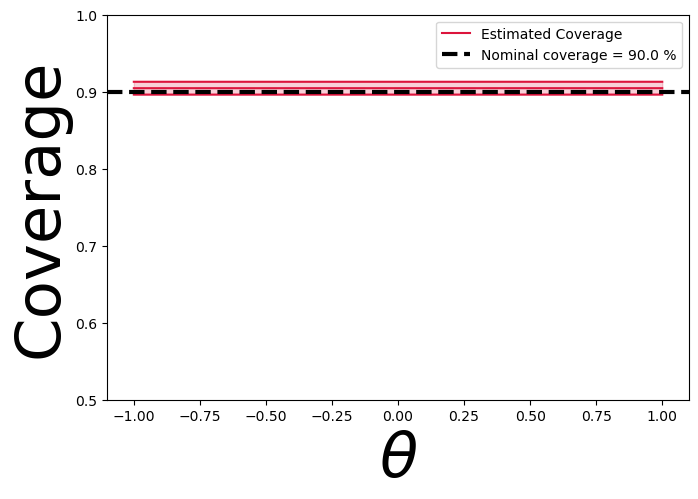

In [14]:
coverage_regions_plot(
    parameters=parameters,
    mean_proba=mean_proba, 
    upper_proba=upper_proba,
    lower_proba=lower_proba,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(7.5, 5),
    ylims=(0.5, 1)
)